In [2]:
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from fractions import Fraction
from hybrid_ode_sim.simulation.simulator import Simulator, ModelGraph
from hybrid_ode_sim.simulation.base import ContinuousTimeModel
from hybrid_ode_sim.simulation.ode_solvers.adaptive_step_solver import RK45

from scipy.integrate import solve_ivp

In [3]:
def compare_ode_solutions(scipy_t, scipy_y, my_t, my_y,
                          state_indices=[0],
                          state_labels=['Position']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Plot scipy_sol
    for i in state_indices:
        ax1.plot(scipy_t, scipy_y[i], label=state_labels[i])
    ax1.set_xlabel('Time')
    ax1.set_ylabel('States')
    ax1.set_title('Scipy Solution')
    ax1.legend()

    # Plot x_history
    for i in state_indices:
        ax2.plot(my_t, my_y[:, i], label=state_labels[i])
    ax2.set_xlabel('Time')
    ax2.set_ylabel('States')
    ax2.set_title('RK45 Solution')
    ax2.legend()

    plt.tight_layout()
    plt.show()

[Simulator] INFO: Simulation Complete! Elapsed Time: 0.02 s (1218.02x real-time)


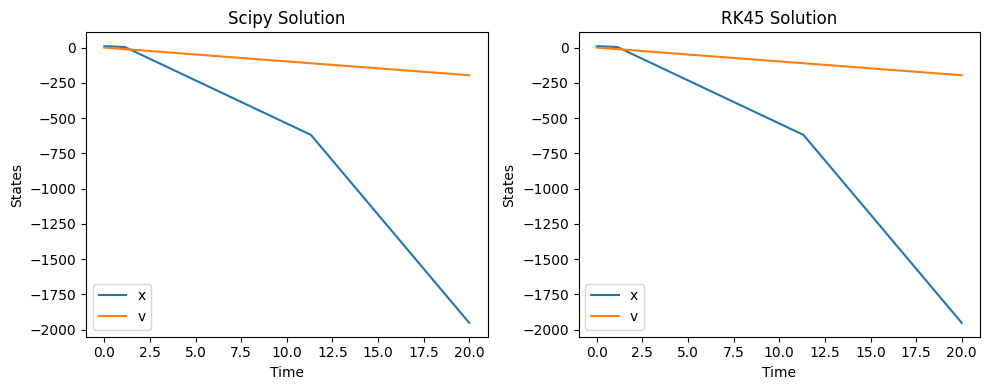

In [4]:
@dataclass
class FallingMassParams:
    m: float = 1.0
    g: float = -9.81
    k: float = 0.0

params = FallingMassParams(1.0, -9.81, 0.0)
t_range = [0.0, 20.0]
y0 = np.array([10.0, 0.0])

def f(t, y):
    return np.array([
        y[1],
        params.g + params.k * y[1] / params.m
    ])

# Falling mass with linear damping
class FallingMass(ContinuousTimeModel):
    def __init__(self, y0: np.ndarray, params: FallingMassParams):
        super().__init__(y0, name="falling_mass", params=params)
    
    def continuous_dynamics(self, t, y) -> np.ndarray:
        return f(t, y)

falling_mass = FallingMass(y0, params)

model_graph = ModelGraph(models=[
    falling_mass
])

simulator = Simulator(model_graph, RK45(atol=1e-9, rtol=1e-6))
simulator.simulate(t_range=t_range)

scipy_sol = solve_ivp(f, t_range, y0, method='RK45', atol=1e-9, rtol=1e-6)
my_sol_t, my_sol_y, _ = falling_mass.history()

compare_ode_solutions(scipy_sol.t, scipy_sol.y,
                      my_sol_t, my_sol_y,
                      state_indices=[0, 1], state_labels=['x', 'v'])

In [5]:
dts = np.diff(my_sol_t)
print(f"Mean dt: {np.mean(dts)}")
print(f"Last position: {my_sol_y[-1, 0]}m -- Analytical: ", y0[0] + y0[1] * t_range[1] + 0.5 * params.g * t_range[1]**2)

Mean dt: 2.857142857142857
Last position: -1952.0m -- Analytical:  -1952.0


In [6]:
@dataclass
class LorenzParams:
    sigma: float
    rho: float
    beta: float

params = LorenzParams(10, 14, 8/3)
t_range = [0.0, 40.0]
y0 = np.array([1, 1, 1])

# Lorenz system of ODEs for `solve_ivp`
def f(_t, y):
    return [
        params.sigma * (y[1] - y[0]),
        y[0] * (params.rho - y[2]) - y[1],
        y[0] * y[1] - params.beta * y[2]
    ]

# Lorenz system of ODEs for `Simulator`
class LorenzAttractor(ContinuousTimeModel):
    def __init__(self, y0: np.ndarray, params: LorenzParams):
        super().__init__(y0, name="lorenz_attractor", params=params)
    
    def continuous_dynamics(self, t, y) -> np.ndarray:
        return [
            self.params.sigma * (y[1] - y[0]),
            y[0] * (self.params.rho - y[2]) - y[1],
            y[0] * y[1] - self.params.beta * y[2]
        ]

In [7]:
lorenz_attractor = LorenzAttractor(y0, params)

model_graph = ModelGraph(models=[
    lorenz_attractor
])

simulator = Simulator(model_graph, RK45(atol=1e-9, rtol=1e-6))
simulator.simulate(t_range=t_range)

scipy_sol = solve_ivp(f, t_range, y0, method='RK45', atol=1e-9, rtol=1e-6)

[Simulator] INFO: Simulation Complete! Elapsed Time: 0.02 s (1822.66x real-time)


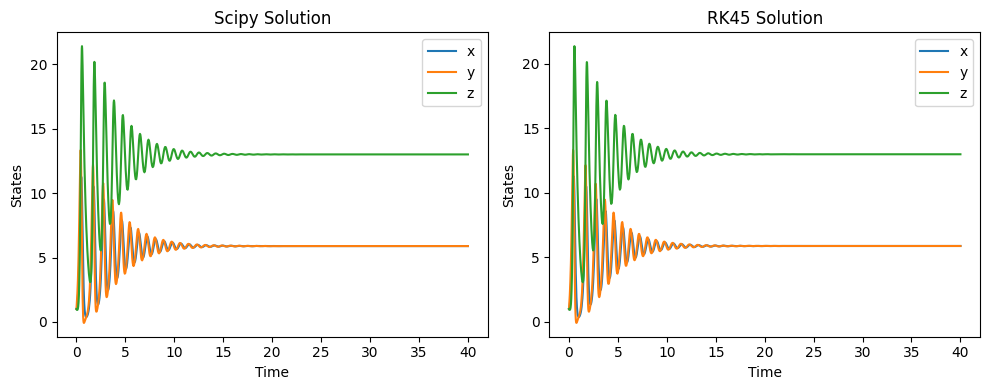

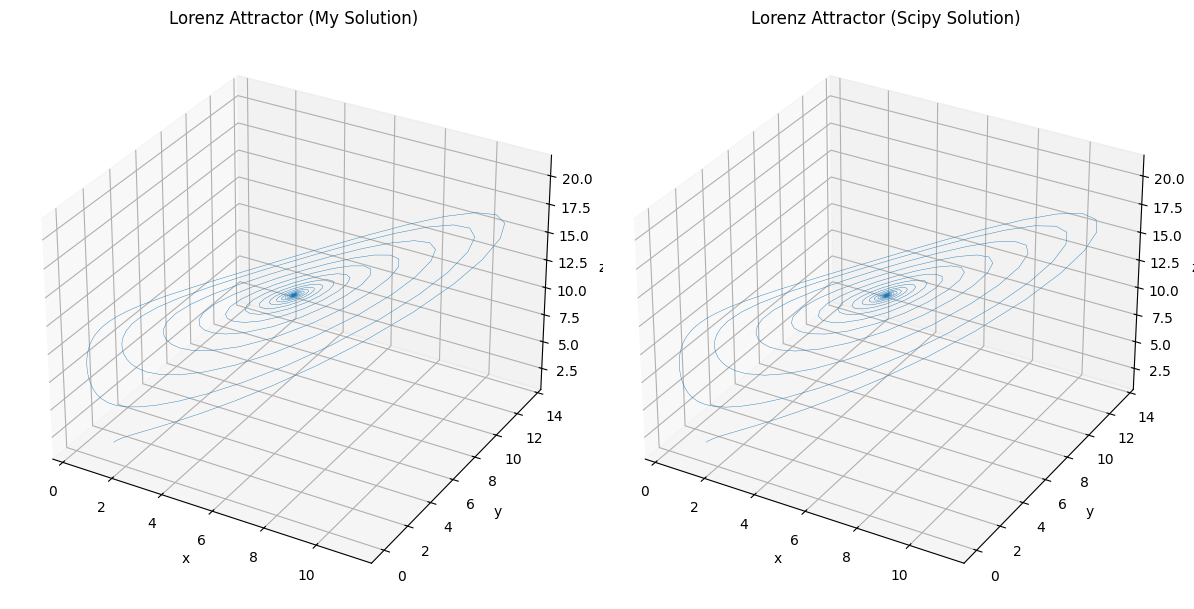

In [9]:
my_sol_t, my_sol_y, _ = lorenz_attractor.history()
# my_sol_y = np.array(lorenz_attractor.state_logger.y_history)

compare_ode_solutions(scipy_sol.t, scipy_sol.y,
                      my_sol_t, my_sol_y,
                      state_indices=[0, 1, 2], state_labels=['x', 'y', 'z'])

# Let's also look at the solution in 3D
fig = plt.figure(figsize=(12, 6))

# Plot the solution from my_sol_y
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(my_sol_y[:, 0], my_sol_y[:, 1], my_sol_y[:, 2], linewidth=0.3)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Lorenz Attractor (My Solution)')

# Plot the solution from scipy_sol.y
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(scipy_sol.y[0], scipy_sol.y[1], scipy_sol.y[2], linewidth=0.3)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('Lorenz Attractor (Scipy Solution)')

plt.tight_layout()
plt.show()